In [1]:
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict, Optional

llm = ChatGroq(
    model="llama-3.1-8b-instant"
)

parser = StrOutputParser()


In [2]:

class TravelState(TypedDict):
    location: Optional[str]
    dates: Optional[str]
    activities: Optional[str]
    step: int
    output: Optional[str]
    complete: bool


In [3]:
def ask_location(state: TravelState) -> TravelState:
    print("Bot: Where would you like to travel?")
    state["location"] = input("You: ")
    return state
def ask_dates(state: TravelState) -> TravelState:
    print(f"Bot: When do you plan to visit {state['location']}?")
    state["dates"] = input("You: ")
    return state
def ask_activities(state: TravelState) -> TravelState:
    print("Bot: What kind of activities do you enjoy? (e.g., museums, beaches, hiking)")
    state["activities"] = input("You: ")
    return state


In [4]:
def generate_itinerary(state: TravelState) -> TravelState:
    prompt = ChatPromptTemplate.from_template("""
Create a short travel itinerary for the following:

Destination: {location}
Dates: {dates}
Activities: {activities}
""")
    chain = prompt | llm | parser
    itinerary = chain.invoke(state)
    
    state["output"] = itinerary
    state["complete"] = True
    return state


In [5]:
def step_router(state: TravelState) -> str:
    if not state["location"]:
        return "ask_location"
    if not state["dates"]:
        return "ask_dates"
    if not state["activities"]:
        return "ask_activities"
    return "generate"


In [6]:
from langgraph.graph import StateGraph

graph = StateGraph(TravelState)

graph.add_node("ask_location", ask_location)
graph.add_node("ask_dates", ask_dates)
graph.add_node("ask_activities", ask_activities)
graph.add_node("generate", generate_itinerary)

graph.set_entry_point("ask_location")

graph.add_conditional_edges("ask_location", step_router, {
    "ask_location": "ask_location",
    "ask_dates": "ask_dates",
    "ask_activities": "ask_activities",
    "generate": "generate"
})

graph.add_conditional_edges("ask_dates", step_router, {
    "ask_location": "ask_location",
    "ask_dates": "ask_dates",
    "ask_activities": "ask_activities",
    "generate": "generate"
})

graph.add_conditional_edges("ask_activities", step_router, {
    "ask_location": "ask_location",
    "ask_dates": "ask_dates",
    "ask_activities": "ask_activities",
    "generate": "generate"
})

graph.add_edge("generate", "__end__")

app = graph.compile()


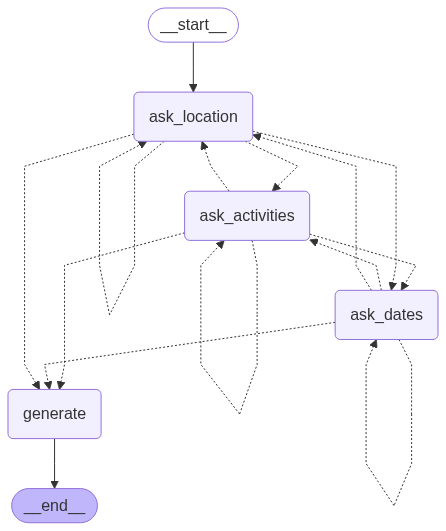

In [8]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
state = {
    "location": None,
    "dates": None,
    "activities": None,
    "step": 0,
    "output": None,
    "complete": False
}

result = app.invoke(state)
print("\n🎯 Final Travel Itinerary:\n", result["output"])


Bot: Where would you like to travel?
Bot: Where would you like to travel?
Bot: When do you plan to visit Goa?
Bot: What kind of activities do you enjoy? (e.g., museums, beaches, hiking)

🎯 Final Travel Itinerary:
 I'm happy to help you with a short travel itinerary for Goa, but I need more information about your trip. However, I can provide you with a general itinerary based on my knowledge about Goa.

**Assumptions:**

* You will be traveling to Goa in July 2025.
* You will be staying in Goa for at least 7 days.
* You will be interested in exploring the beaches, culture, and adventure activities of Goa.

**Itinerary:**

**Day 1: 20/7/2025 - Arrival in Goa**

* Arrive at Dabolim Airport (GOI) or by bus/train from neighboring cities.
* Check-in to your hotel and freshen up.
* Visit the nearby beaches, such as Baga Beach or Calangute Beach, to get a feel for the laid-back atmosphere of Goa.

**Day 2: 21/7/2025 - Explore North Goa**

* Start the day with a delicious breakfast at a local e